In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter

In [2]:

# Step 1: Load datasets
file_path = 'dataset.xlsx'  # Ubah ke lokasi file Anda
data_ik = pd.read_excel(file_path, sheet_name='DATA IK')
data_ib = pd.read_excel(file_path, sheet_name='DATA IB')

In [3]:
# Step 2: Preprocessing - Combine and clean data
data_ik = data_ik[['tujuan']].rename(columns={'tujuan': 'keperluan'})
data_ib = data_ib[['desc']].rename(columns={'desc': 'keperluan'})
data_combined = pd.concat([data_ik, data_ib], ignore_index=True)
data_combined.dropna(subset=['keperluan'], inplace=True)

In [4]:
# Step 3: Clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus simbol dan angka
    text = re.sub(r"\s+", " ", text).strip()  # Menghapus whitespace berlebih
    return text

data_combined['keperluan'] = data_combined['keperluan'].apply(clean_text)


In [5]:
# Step 4: Count unique words
all_text = " ".join(data_combined['keperluan'])
word_counts = Counter(all_text.split())
top_words = word_counts.most_common(10)  # TOP 10 words
print("Top 10 Words by Frequency:")
for word, count in top_words:
    print(f"{word}: {count}")

Top 10 Words by Frequency:
pulang: 25264
rumah: 19718
ke: 18486
bertemu: 15078
libur: 14995
orang: 11005
tua: 10881
keluarga: 10727
kerumah: 9388
dan: 7383


In [6]:
# Step 5: Categorize "keperluan"
def classify_keperluan(text):
    if re.search(r"(laptop|printer|service|barang)", text):
        return "Memperbaiki Barang"
    elif re.search(r"(orangtua|keluarga|pulang|rumah|bertemu)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek|PKM|tugas|makalah|observasi|akhir|data)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|sakit|berobat|obat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(membeli|pribadi|mengurus|rekening|tabungan)", text):
        return "Urusan Pribadi"
    elif re.search(r"(wisuda|graduation|clearance)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

data_combined['kategori'] = data_combined['keperluan'].apply(classify_keperluan)

In [7]:

# Mengurutkan kategori berdasarkan jumlah
kategori_counts = data_combined['kategori'].value_counts()
data_combined['kategori'] = pd.Categorical(data_combined['kategori'], categories=kategori_counts.index, ordered=True)

In [8]:
# Step 6: TF-IDF Vectorization
factory = StopWordRemoverFactory()
stop_words_indonesian = factory.get_stop_words()

vectorizer = TfidfVectorizer(max_features=500, stop_words=stop_words_indonesian)
X = vectorizer.fit_transform(data_combined['keperluan']).toarray()
y = data_combined['kategori']


In [9]:
# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Step 8: Hyperparameter Tuning for Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}
grid_search = GridSearchCV(dt_model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters for Decision Tree:", best_params)

# Train the Decision Tree with best parameters
dt_model = DecisionTreeClassifier(random_state=42, **best_params)
dt_model.fit(X_train, y_train)


Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 30}


DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=30,
                       random_state=42)

Classification Report:
                     precision    recall  f1-score   support

  Bertemu Keluarga       1.00      1.00      1.00     10279
           Lainnya       1.00      1.00      1.00      4742
Memperbaiki Barang       1.00      0.99      1.00       185
   Pergi ke Klinik       1.00      1.00      1.00       232
      Tamat Kuliah       1.00      0.98      0.99       226
      Tugas Kuliah       1.00      1.00      1.00       292
    Urusan Pribadi       1.00      1.00      1.00       118

          accuracy                           1.00     16074
         macro avg       1.00      1.00      1.00     16074
      weighted avg       1.00      1.00      1.00     16074



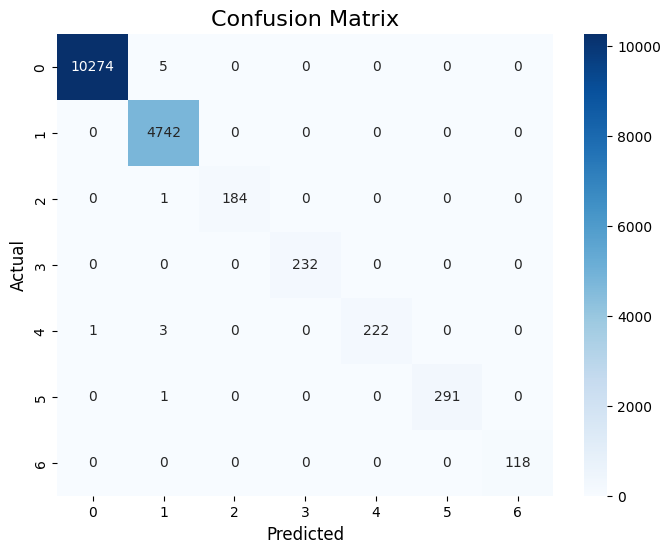

In [11]:

# Step 9: Evaluate Model
y_pred = dt_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


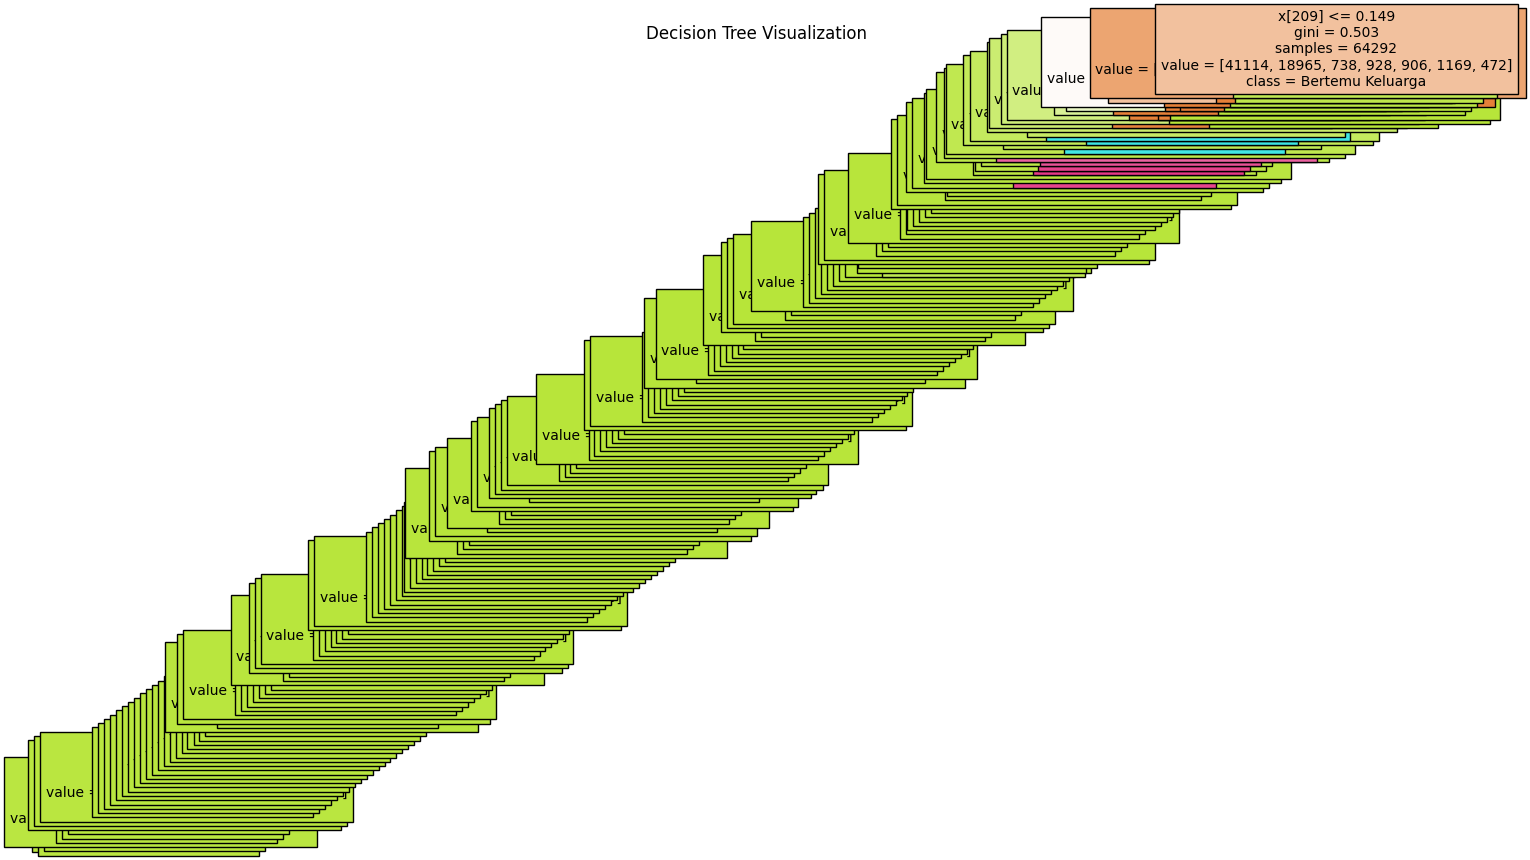

In [12]:

# Step 10: Visualize Decision Tree
plt.figure(figsize=(16, 10))
plot_tree(dt_model, class_names=dt_model.classes_, filled=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


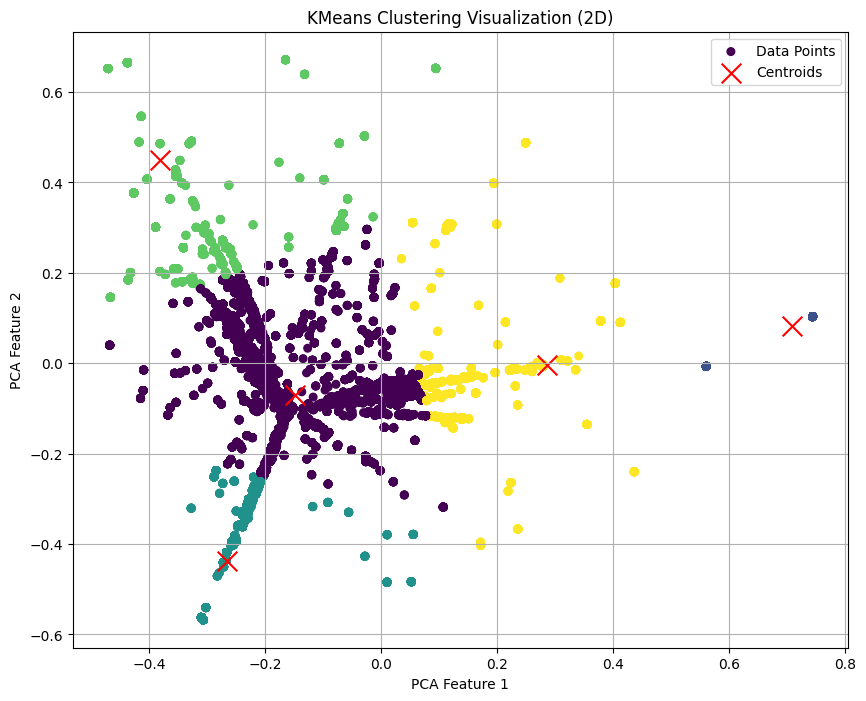

In [13]:
# Step 11: K-Means Clustering
pca = PCA(n_components=2)  # Reduksi ke 2 dimensi
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20).fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', marker='o', s=30, label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("KMeans Clustering Visualization (2D)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend()
plt.grid(True)
plt.show()


In [14]:

# Step 12: Add Business Opportunities Based on Category
recommendations = {
    "Bertemu Keluarga": "Jasa Transportasi dan Ruang Pertemuan",
    "Pergi ke Klinik": "Klinik Kesehatan atau Apotek",
    "Tugas Kuliah": "Pusat Fotokopi atau Jasa Pengetikan",
    "Memperbaiki Barang": "Toko Elektronik atau Reparasi Barang",
    "Urusan Pribadi": "Layanan Logistik atau Pengurusan Dokumen",
    "Tamat Kuliah": "Jasa Fotografi atau Penyewaan Kostum",
    "Lainnya": "Usaha General seperti Minimarket"
}


In [15]:

# Step 13: Create Summary Table for Business Opportunities
summary_table = pd.DataFrame({
    "Kategori": kategori_counts.index,
    "Peluang Bisnis": [recommendations.get(kategori, "Lainnya") for kategori in kategori_counts.index]
})

print("\nSummary Table with Business Opportunities:")
print(summary_table)


Summary Table with Business Opportunities:
             Kategori                            Peluang Bisnis
0    Bertemu Keluarga     Jasa Transportasi dan Ruang Pertemuan
1             Lainnya          Usaha General seperti Minimarket
2        Tugas Kuliah       Pusat Fotokopi atau Jasa Pengetikan
3     Pergi ke Klinik              Klinik Kesehatan atau Apotek
4        Tamat Kuliah      Jasa Fotografi atau Penyewaan Kostum
5  Memperbaiki Barang      Toko Elektronik atau Reparasi Barang
6      Urusan Pribadi  Layanan Logistik atau Pengurusan Dokumen


In [16]:
# Step 14: Export categorized data (optional)
data_combined.to_csv("categorized_keperluan.csv", index=False)
print("Data dengan kategori berhasil diekspor ke 'categorized_keperluan.csv'.")

Data dengan kategori berhasil diekspor ke 'categorized_keperluan.csv'.
